# Notebook to plot inference results.

In [2]:
from src.plotting import (
    load_1d_experiment,
    load_2d_experiment,
    plot_box_overlap,
)
from src.utils import frobenius_error_normalized
from src.parameters import compute_real_theta_from_config
import numpy as np
import matplotlib.pyplot as plt
# auto reload
%load_ext autoreload
%autoreload 2



# VAR(1) plots

In [3]:
base_dir = "inference_results/"
experiment_name = "VAR1 (n=100)"
theta_names = ["A", "$\\Sigma$"]

# Load the experiment data
df, exp_config = load_2d_experiment(base_dir, experiment_name)
true_thetas = compute_real_theta_from_config(exp_config)

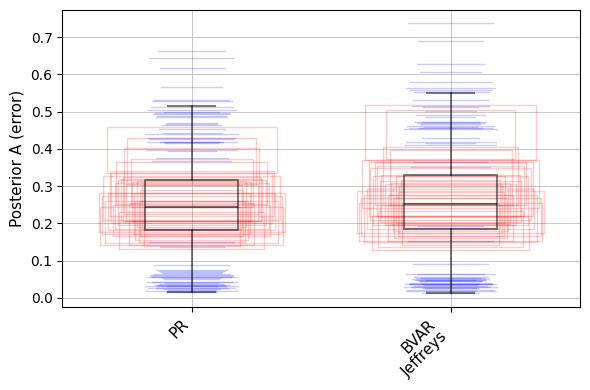

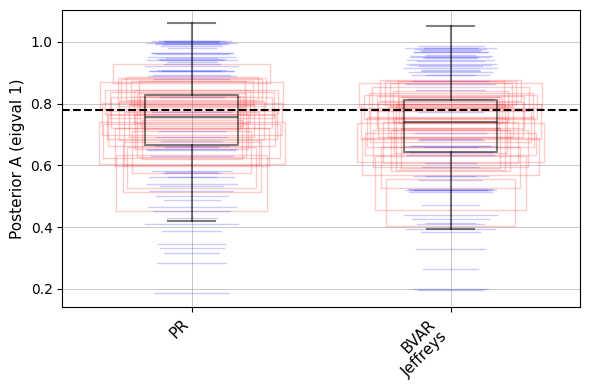

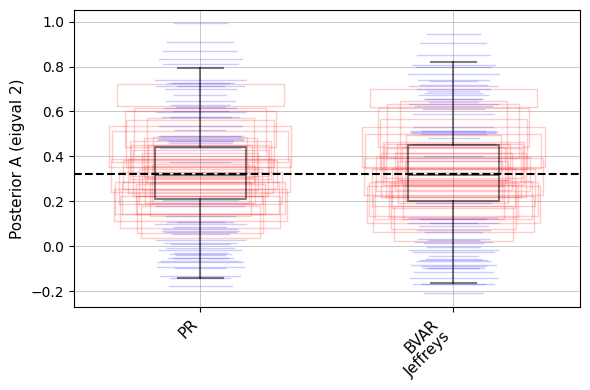

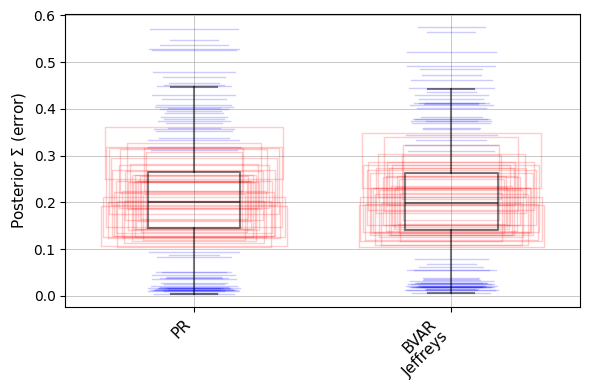

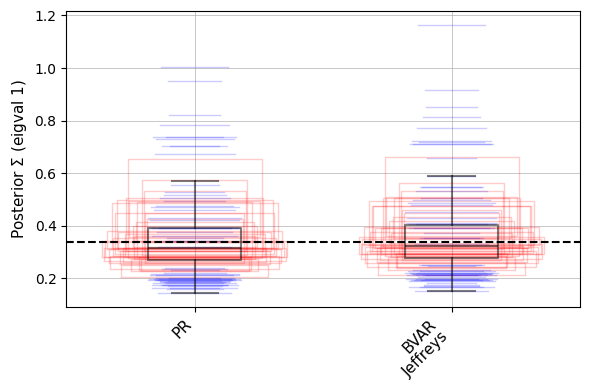

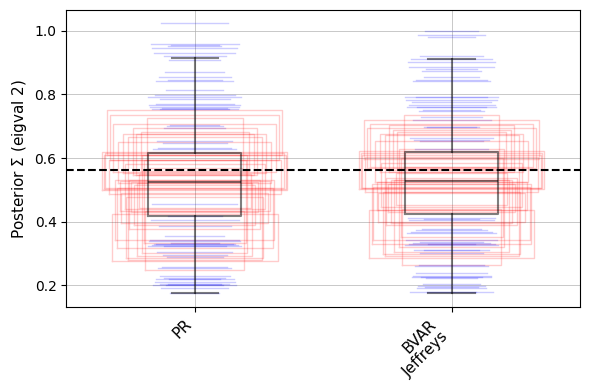

In [ ]:

methods = [
    'PR',
    'BVAR\nJeffreys',
    # 'LP\nInform. prior',
    # 'LP\nWrong Student-T L'
]
# Iterating over all therta
for theta_name in theta_names:
    # Load the true theta
    true_theta = np.array(true_thetas[theta_name])
    # Filter the DataFrame for the current theta
    df_theta_err = df[df['theta'] == theta_name].copy()
    # Changing sample to be the error
    df_theta_err['sample'] = [
        frobenius_error_normalized(np.asarray(theta_sample), true_theta)
        for theta_sample in df_theta_err['sample']
    ]  
    # renaming the "theta" for consistency
    df_theta_err['theta'] = f"{theta_name} (error)"

    # plotting error boxplot
    plot_box_overlap(
        df_theta_err[df_theta_err['method'].isin(methods)],
        f"{theta_name} (error)",
        alpha=0.2,
    )
    fig_name = f"box_overlap_{experiment_name}_{theta_name}_error"
    plt.savefig(
        f"plots/boxplots/box_overlap/{fig_name.replace(' ', '_').replace('.', '').replace(',', '').replace(r'\\', '').replace('$', '').lower()}_no_minnesota.png",
        bbox_inches='tight'
    )
    plt.show()
    del df_theta_err

    # plotting eigval 1 boxplot
    df_theta_eigval1 = df[df['theta'] == theta_name].copy()
    df_theta_eigval1['sample'] = [
        np.real(np.linalg.eigvals(np.asarray(theta_sample))[0])
        for theta_sample in df_theta_eigval1['sample']
    ]
    df_theta_eigval1['theta'] = f"{theta_name} (eigval 1)"
    real_theta_eigval1 = np.real(np.linalg.eigvals(true_theta)[0])


    plot_box_overlap(
        df_theta_eigval1[df_theta_eigval1['method'].isin(methods)],
        f"{theta_name} (eigval 1)",
        alpha=0.2,
        true_theta=real_theta_eigval1
    )
    fig_name = f"box_overlap_{experiment_name}_{theta_name}_eigval1"
    plt.savefig(
        f"plots/boxplots/box_overlap/{fig_name.replace(' ', '_').replace('.', '').replace(',', '').replace(r'\\', '').replace('$', '').lower()}_no_minnesota.png",
        bbox_inches='tight'
    )
    plt.show() 
    del df_theta_eigval1

    # plotting eigval 2 boxplot
    df_theta_eigval2 = df[df['theta'] == theta_name].copy()
    df_theta_eigval2['sample'] = [
        np.real(np.linalg.eigvals(np.asarray(theta_sample))[1])
        for theta_sample in df_theta_eigval2['sample']
    ]
    df_theta_eigval2['theta'] = f"{theta_name} (eigval 2)"
    real_theta_eigval2 = np.real(np.linalg.eigvals(true_theta)[1])
    plot_box_overlap(
        df_theta_eigval2[df_theta_eigval2['method'].isin(methods)],
        f"{theta_name} (eigval 2)",
        alpha=0.2,
        true_theta=real_theta_eigval2
    )
    fig_name = f"box_overlap_{experiment_name}_{theta_name}_eigval2"
    plt.savefig(
        f"plots/boxplots/box_overlap/{fig_name.replace(' ', '_').replace('.', '').replace(',', '').replace(r'\\', '').replace('$', '').lower()}_no_minnesota.png",
        bbox_inches='tight'
    )
    plt.show()
    del df_theta_eigval2


# Normal (n=100) plots

In [6]:
base_dir = "inference_results/"
experiment_name = "Normal, n=100"
theta_names = ["mean", "std", "skewness", "kurtosis", "VaR_95"]

# Load the experiment data
df, exp_config = load_1d_experiment(base_dir, experiment_name)
true_thetas = compute_real_theta_from_config(exp_config)

In [7]:
df.method.unique()

array(['PR\nEmpirical', 'PR\nNormal', 'LP\nJeffreys', 'LP\nInform. prior',
       'LP\nWrong Student-T L'], dtype=object)

In [ ]:
#considered methods
methods = [
    'PR\nEmpirical',
    'PR\nNormal',
    'LP\nJeffreys',
    # 'LP\nInform. prior',
    # 'LP\nWrong Student-T L'
]

# Iterating over all therta
for theta_name in theta_names:
    # Load the true theta
    true_theta = np.array(true_thetas[theta_name])
    #PLotting boxplot
    plot_box_overlap(
        df[df['method'].isin(methods)],
        f"{theta_name}",
        alpha=0.3,
        true_theta=true_theta,
    )
    fig_name = f"box_overlap_{experiment_name}_{theta_name}"
    fig = plt.gcf()
    #saving the figure
    fig.savefig(
        f"plots/boxplots/box_overlap/{fig_name.replace(' ', '_').replace('.', '').replace(',', '').lower()}.png",
        bbox_inches='tight'
    )
    plt.show()

# Student-t (nu=10, n=100) plots

In [10]:
base_dir = "inference_results/"
experiment_name = "Student-T, nu=10, n=100"
theta_names = ["mean", "std", "skewness", "kurtosis", "VaR_95"]

# Load the experiment data
df, exp_config = load_1d_experiment(base_dir, experiment_name)
true_thetas = compute_real_theta_from_config(exp_config)
df.method.unique()

array(['PR\nEmpirical', 'PR\nNormal', 'PR\nStudent-t', 'LP\nJeffreys',
       'LP\n(wrong) Normal\n Likelihood'], dtype=object)

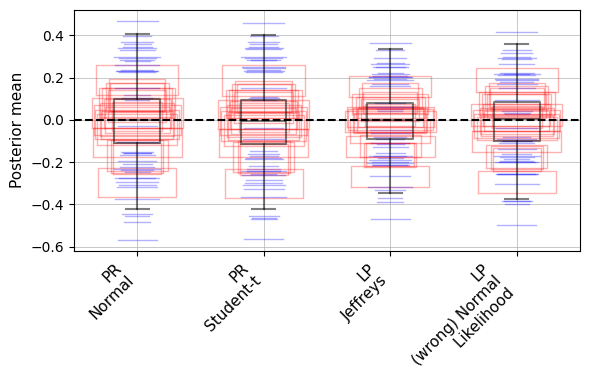

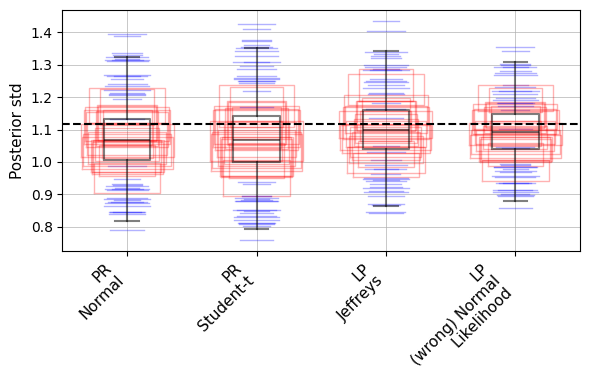

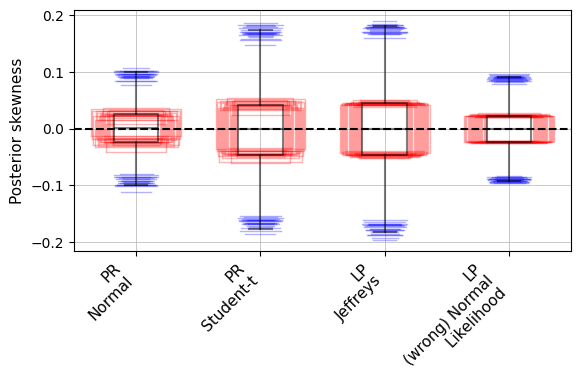

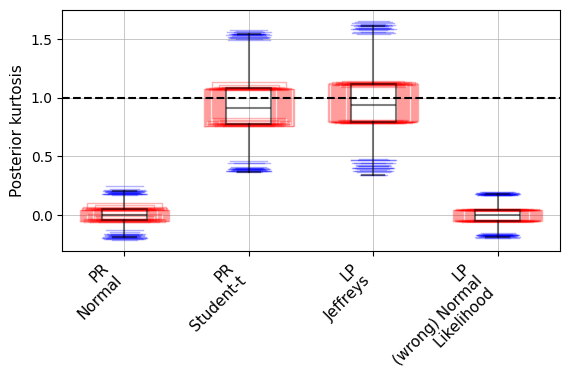

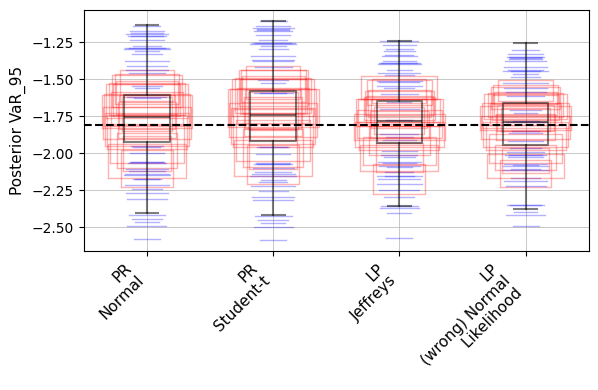

In [11]:
#considered methods
methods = ['PR\nNormal', 'PR\nStudent-t', 'LP\nJeffreys',
       'LP\n(wrong) Normal\n Likelihood']

# Iterating over all therta
for theta_name in theta_names:
    # Load the true theta
    true_theta = np.array(true_thetas[theta_name])
    #PLotting boxplot
    plot_box_overlap(
        df[df['method'].isin(methods)],
        f"{theta_name}",
        alpha=0.3,
        true_theta=true_theta,
    )
    fig_name = f"box_overlap_{experiment_name}_{theta_name}"
    plt.savefig(
        f"plots/boxplots/box_overlap/{fig_name.replace(' ', '_').replace('.', '').replace(',', '').lower()}.png",
        bbox_inches='tight'
    )
    plt.show()

# SkewNormal (alpha=-2, n=100) plots

In [12]:
base_dir = "inference_results/"
experiment_name = "SkewNormal, alpha=-2, n=100"
theta_names = ["mean", "std", "skewness", "kurtosis", "VaR_95"]

# Load the experiment data
df, exp_config = load_1d_experiment(base_dir, experiment_name)
true_thetas = compute_real_theta_from_config(exp_config)
df.method.unique()

array(['PR\nEmpirical', 'PR\nNormal', 'LP\nJeffreys',
       'LP\n(wrong) Normal\n Likelihood'], dtype=object)

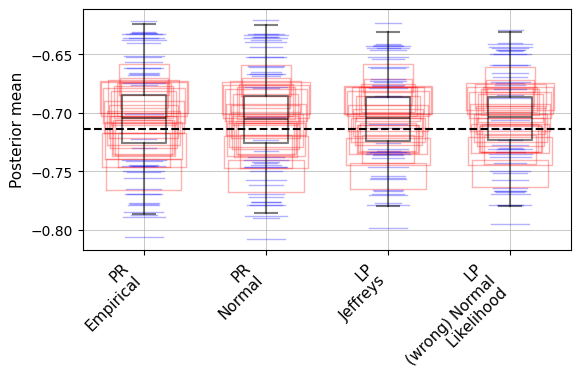

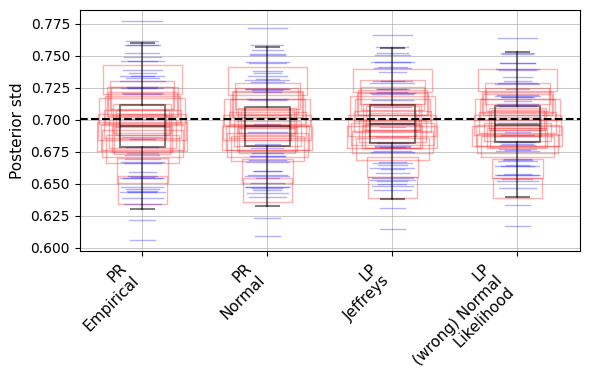

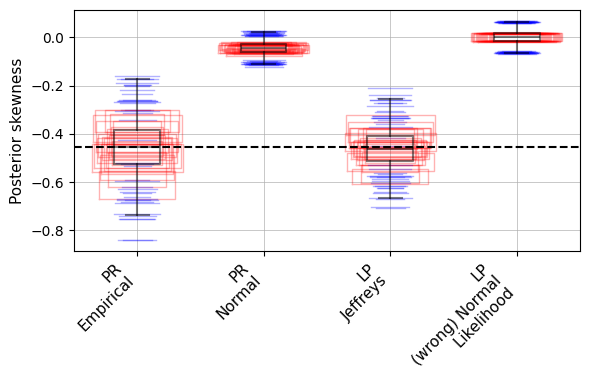

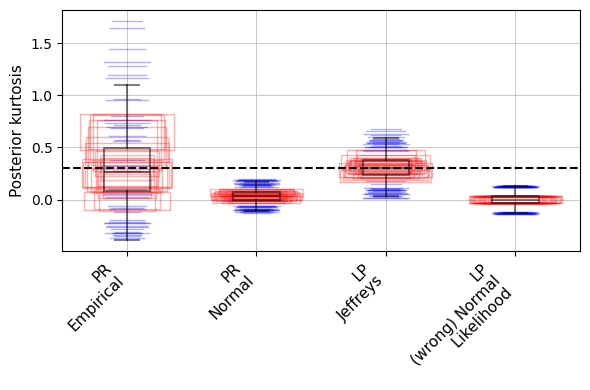

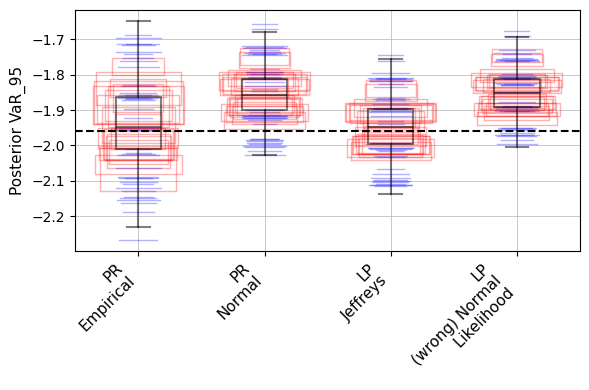

In [13]:
#considered methods
methods = ['PR\nEmpirical', 'PR\nNormal', 'LP\nJeffreys',
       'LP\n(wrong) Normal\n Likelihood']

# Iterating over all therta
for theta_name in theta_names:
    # Load the true theta
    true_theta = np.array(true_thetas[theta_name])
    #PLotting boxplot
    plot_box_overlap(
        df[df['method'].isin(methods)],
        f"{theta_name}",
        alpha=0.3,
        true_theta=true_theta,
    )
    fig_name = f"box_overlap_{experiment_name}_{theta_name}"
    plt.savefig(
        f"plots/boxplots/box_overlap/{fig_name.replace(' ', '_').replace('.', '').replace(',', '').lower()}.png",
        bbox_inches='tight'
    )
    plt.show()

# Other plots (seeded plots)

In [9]:
from src.utils import load_inference_results, get_theta_samples_errors, rename_keys
from src.parameters import compute_real_theta_from_config, THETA_HAT_FUNC_DICT, TRUE_THETA_FUNC_DICT
from src.plotting_old import (
    plot_posterior_distributions,
    plot_posterior_boxplots,
    plot_posterior_eigvals_boxplots,
)
import matplotlib.pyplot as plt
import numpy as np
# auto reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from matplotlib.patches import Patch
# Constants for nicer names in plots
NICE_NAMES = {
    "VAR1_A_hat": "A",
    "VAR1_sigma_eps_hat": "$\\Sigma$",
    "resampling_var1_2d": "PR",
    "bayesian_bvar_analytical": "BVAR\nJeffreys",
    "bayesian_bvar_minnesota_wrong": "BVAR\nMinnesota\n(uninf.)",
    "bayesian_bvar_minnesota_chat_gpt": "BVAR\nMinnesota\n(ChatGPT)",
    "LP\nUninf. prior": "LP\nJeffreys",
    "PR\nStudent-T": "PR\nStudent-t",
    "LP\nWrong Normal L": "LP\n(wrong) Normal\n Likelihood",
}

def plot_seeded_boxplots(base_exp_name: str, seeds: list[int], theta_name: str, remove_methods: list[str] = []):
    from matplotlib.cm import get_cmap

    cmap = get_cmap("tab10")
    color_map = {seed: cmap(i % 10) for i, seed in enumerate(seeds)}
    k = len(seeds)

    sample_groups = {}
    method_list = []

    for seed in seeds:
        exp_name = f"{base_exp_name}, seed={seed}"
        results, config, X_obs = load_inference_results(exp_name)
        results = rename_keys(results, NICE_NAMES)
        theta_hat = THETA_HAT_FUNC_DICT[theta_name](X_obs)
        for method, samples in results[theta_name].items():
            if method not in remove_methods:
                if method not in sample_groups:
                    sample_groups[method] = []
                    method_list.append(method)
                sample_groups[method].append((samples, seed, theta_hat))

    method_spacing = 0.15
    width = 0.5 / k
    all_samples = []
    all_positions = []
    all_colors = []
    all_obs_lines = []

    pos = 0
    yticks = []
    yticklabels = []

    for method in method_list[::-1]:
        entries = sample_groups[method]
        for i, (samples, seed, theta_hat) in enumerate(entries):
            samples = samples[~np.isnan(samples)]
            all_samples.append(samples)
            all_positions.append(pos)
            all_colors.append(color_map[seed])
            all_obs_lines.append((theta_hat, pos, color_map[seed]))
            pos += 0.6/k
        pos += method_spacing  # space between method blocks
        # Pos for labels
        method_positions = all_positions[-len(entries):]  # last k positions for this method
        yticks.append(np.mean(method_positions))
        yticklabels.append(method)

    base_height = 4
    fig_height = base_height + 0.5 * len(method_list)
    fig, ax = plt.subplots(figsize=(8, fig_height))

    box = ax.boxplot(
        all_samples,
        vert=False,
        positions=all_positions,
        widths=width,
        patch_artist=True,
        showfliers=False,
        whis=1.5
    )

    for patch, color in zip(box['boxes'], all_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    for median in box['medians']:
        median.set_color('black')

    for x, y, color in all_obs_lines:
        ax.axvline(x=x, ymin=0, ymax=1, color=color, linestyle=":", linewidth=1)

    true_theta = compute_real_theta_from_config(config)[theta_name]
    ax.axvline(x=true_theta, color="black", linestyle="--", linewidth=1.5, label='True θ')

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, fontsize=11, rotation=45)
    ax.set_xlabel(f"Posterior {theta_name}", fontsize=11)
    # ax.set_title(f"Posterior Boxplots $\\theta=$`{theta_name}` ({base_exp_name})", fontsize=12)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    legend_handles = [
        # plt.Line2D([0], [0], color='black', linestyle="--", label="Real $\\theta$"),
        # plt.Line2D([0], [0], color='black', linestyle=":", label="$\\hat{\\theta}_{obs}$"),
    ]
    legend_handles += [
        Patch(color=color_map[seed], label=f"seed={seed}", alpha=0.6)
        for seed in seeds
    ]
    ax.legend(handles=legend_handles, loc="upper right")

    plt.tight_layout()
    print(method_list)
    return fig, ax

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch

def plot_seeded_eigen_boxplots(
    base_exp_name: str,
    seeds: list[int],
    theta_name: str,
    remove_methods: list[str] = []
):
    """
    Plot two side-by-side subplots of eigenvalue boxplots
    for each posterior sample matrix (sorted), sharing y-ticks,
    having independent x-axes, legend at top, and fontsize=11.
    """
    # color map for seeds
    cmap = get_cmap("tab10")
    color_map = {seed: cmap(i % 10) for i, seed in enumerate(seeds)}

    # 1) collect matrices and observed
    sample_groups = {}
    method_list = []
    for seed in seeds:
        exp_name = f"{base_exp_name}, seed={seed}"
        results, config, X_obs = load_inference_results(exp_name)
        results = rename_keys(results, NICE_NAMES)
        theta_hat_mat = THETA_HAT_FUNC_DICT[theta_name](X_obs)
        for method, mats in results[theta_name].items():
            if method in remove_methods:
                continue
            sample_groups.setdefault(method, []).append((mats, seed, theta_hat_mat))
            if method not in method_list:
                method_list.append(method)

    # 2) compute eigenvalues
    eigen_data = {0: {}, 1: {}}
    true_theta_mat = compute_real_theta_from_config(config)[theta_name]
    true_eigs = np.sort(np.linalg.eigvals(true_theta_mat).real)

    for method in method_list:
        for mats, seed, theta_hat_mat in sample_groups[method]:
            M = np.array(mats)
            evs = np.sort(np.linalg.eigvals(M).real, axis=1)
            obs_evs = np.sort(np.linalg.eigvals(theta_hat_mat).real)
            for idx in (0, 1):
                eigen_data[idx].setdefault(method, []).append(
                    (evs[:, idx], seed, obs_evs[idx], true_eigs[idx])
                )

    # 3) setup figure: two independent x-axes, shared y-axis
    n_methods = len(method_list)
    fig, axes = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(10, 4 + 0.5 * n_methods),
        sharey=True,
        sharex=False
    )
    fig.subplots_adjust(left=0.06, right=0.98, wspace=0.35, top=0.88)

    legend_handles = []

    # 4) plot for each eigen index
    for ax, ev_idx in zip(axes, (0, 1)):
        all_samples, positions, colors, obs_lines = [], [], [], []
        pos = 0
        yticks, yticklabels = [], []
        x_min, x_max = np.inf, -np.inf

        for method in method_list[::-1]:
            entries = eigen_data[ev_idx][method]
            for vals, seed, obs_ev, true_ev in entries:
                clean = vals[~np.isnan(vals)]
                all_samples.append(clean)
                positions.append(pos)
                colors.append(color_map[seed])
                obs_lines.append((obs_ev, pos, color_map[seed]))
                if clean.size:
                    x_min = min(x_min, clean.min())
                    x_max = max(x_max, clean.max())
                pos += 0.6 / len(seeds)
            pos += 0.4  # space between method blocks
            block = positions[-len(entries):]
            yticks.append(np.mean(block))
            yticklabels.append(method)

        # draw boxplot
        box = ax.boxplot(
            all_samples,
            vert=False,
            positions=positions,
            widths=(0.5 / len(seeds)),
            patch_artist=True,
            showfliers=False,
            whis=1.5
        )
        for patch, c in zip(box['boxes'], colors):
            patch.set_facecolor(c)
            patch.set_alpha(0.6)
        for med in box['medians']:
            med.set_color('black')

        # observed & true lines
        for x, y, c in obs_lines:
            ax.axvline(x=x, ymin=0, ymax=1, color=c, linestyle=":", linewidth=1)
        ax.axvline(x=true_eigs[ev_idx], color="black", linestyle="--", linewidth=1.5)

        # set axis limits with small margin
        if x_min < x_max:
            m = 0.05*(x_max-x_min)
            ax.set_xlim(x_min - m, x_max + m)

        # labels & ticks
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels, fontsize=11)
        ax.set_xlabel(f"Posterior eigenvalue #{ev_idx+1} (real part)", fontsize=11)
        ax.tick_params(axis='x', labelsize=11)
        ax.tick_params(axis='y', labelsize=11)
        ax.grid(axis='x', linestyle='--', alpha=0.7)

        # collect legend handles one time
        if not legend_handles:
            legend_handles = [Patch(color=color_map[s], label=f"seed={s}", alpha=0.6)
                              for s in seeds]
            legend_handles += [
                # Patch(facecolor='none', edgecolor='black', linestyle='--', label='True λ'),
                # Patch(facecolor='none', edgecolor='black', linestyle=':', label='Observed λ̂')
            ]

    # shared legend above both plots
    fig.legend(
        handles=legend_handles,
        loc='upper right',
        ncol=len(legend_handles),
        fontsize=11,
        frameon=True #False
    )
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    return fig, axes



/tmp/ipykernel_985/2697942492.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")


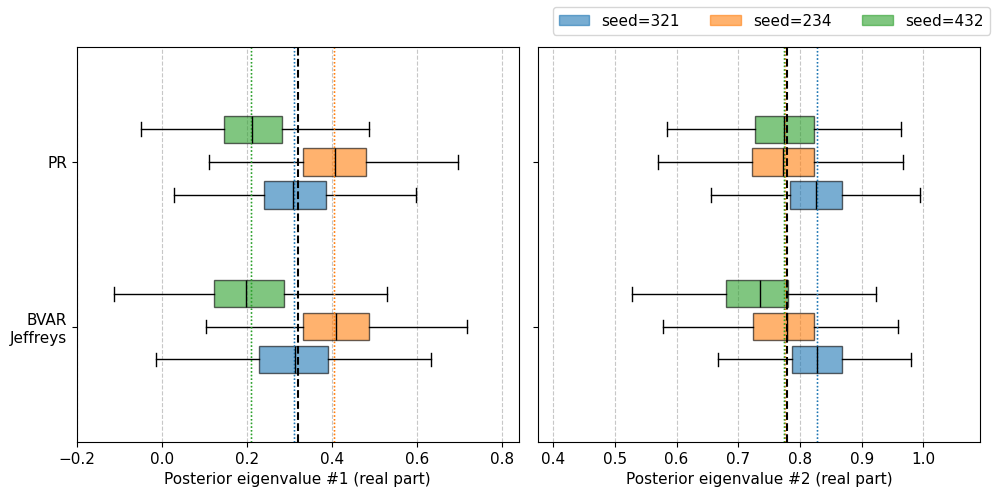

In [51]:
base_exp_name = "VAR1 (n=100)"
seeds = [321, 234, 432]
theta_name = "A"
remove_methods = ["BVAR\nMinnesota\n(uninf.)", "BVAR\nMinnesota\n(ChatGPT)"]
fig, ax = plot_seeded_eigen_boxplots(
    base_exp_name, seeds, theta_name, remove_methods
)
plt.savefig(
    f"plots/boxplots/{base_exp_name}_eigenvalues.png",
    bbox_inches='tight'
)
plt.show()

In [ ]:
base_exp_name = "Student-T, nu=10, n=100"
remove_methods = [
    'PR\nEmpirical',
    # 'PR\nNormal',
    # 'LP\nUninf. prior',
    'LP\nInform. prior',
    'LP\nWrong Student-T L',
    # 'LP\nWrong Normal L',
]
theta_names = ["mean", "std", "skewness", "kurtosis", "VaR_95"]
seeds = [321, 234, 432]
for theta_name in theta_names:
    plot_seeded_boxplots(base_exp_name, seeds, theta_name, remove_methods=remove_methods)
    plt.savefig(
        f"plots/boxplots/{base_exp_name.replace(' ', '_').replace('.', '').replace(',', '').lower()}_{theta_name}_NO_EMPIRICAL.png",
        bbox_inches='tight'
    )
    plt.show()

### VAR(1) simulations


In [16]:

# Setting experiment
experiment_name = "VAR1 (n=100)"
theta_name = "VAR1_A_hat"
remove_methods = [
    # "bayesian_incorrect_likelihood"
    # "bayesian_bvar_analytical",
    "bayesian_bvar_uninformative",
    # "bayesian_bvar_minnesota_wrong",
    # "bayesian_bvar_minnesota_chat_gpt",
    "bayesian_bvar_minnesota"
]

# Loading & preparing results
experiment_results, experiment_config, X_obs = load_inference_results(experiment_name)
theta_samples = experiment_results[theta_name]
for method in remove_methods:
    if method in theta_samples:
        del theta_samples[method]
true_theta = np.array(experiment_config['A'])
theta_hat_obs = THETA_HAT_FUNC_DICT[theta_name](X_obs)

theta_samples = {
    method: np.array(samples) for method, samples in theta_samples.items() if method not in remove_methods
}

# PLotting boxplots of eigenvalues
fig, axes = plot_posterior_eigvals_boxplots(
    theta_samples=theta_samples,
    true_theta=true_theta,
    theta_hat_obs=theta_hat_obs,
)
# Make plot nicers
axes[0].set_xlabel("$\\lambda_1$")
axes[1].set_xlabel("$\\lambda_2$")
# change yticks label by getting the current y-tick labels

axes[0].set_yticklabels(
    ["PR", "BVAR\n(Jeffreys)", "BVAR\n(Minnesota, uninf.)", "BVAR\n(Minnesota, ChatGPT)"],
    fontsize=10,
)
fig.suptitle(f"Boxplots of the posterior sample eigenvalues of $A$ ({experiment_name})")
fig.tight_layout()
plt.show()



/home/charl/repos/bayesian-prediction/src/utils.py:153: SyntaxWarning: invalid escape sequence '\h'
  """


FileNotFoundError: [Errno 2] No such file or directory: 'inference_results/VAR1 (n=100)/inferences.json'

In [ ]:

# Plotting normalized errors
theta_error_samples = get_theta_samples_errors(theta_samples, true_theta)
plot_posterior_distributions(
    theta_samples=theta_error_samples,
    # true_theta=0.0,
    theta_hat_obs=np.linalg.norm(theta_hat_obs - true_theta, ord='fro')/np.linalg.norm(true_theta, ord='fro'),
    plot_type='density',
    bins=100,
    figsize=(10, 6),
    title=f"Posterior Distributions of $A$ normalized errors ({experiment_name})",
    xlabel='Errors',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
)
fig, ax = plt.gcf(), plt.gca()
# changing legend names
handles, labels = plt.gca().get_legend_handles_labels()
handles = [h for h, l in zip(handles, labels) if l not in remove_methods]
labels = ["PR", "BVAR\n(Jeffreys)", "BVAR\n(Minnesota, uninf.)", "BVAR\n(Minnesota, ChatGPT)"]
plt.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.show()

# boxplot
fig, ax = plot_posterior_boxplots(
    theta_samples=theta_error_samples,
    # true_theta=0.0,
    theta_hat_obs=np.linalg.norm(theta_hat_obs - true_theta, ord='fro')/np.linalg.norm(true_theta, ord='fro'),
    title="",
    xlabel='Normalized Error',
)
# change yticks label by getting the current y-tick labels
ax.set_yticklabels(
    ["PR", "BVAR\n(Jeffreys)", "BVAR\n(Minnesota, uninf.)", "BVAR\n(Minnesota, ChatGPT)"],
    fontsize=11
)
fig.tight_layout()
plt.title(f"Posterior Boxplots of $A$ normalized errors ({experiment_name})")
plt.legend()
plt.show()


# PLots to choose N

In [ ]:
from src.chooseN_pipeline import choose_N_1D

experiment_name = "Normal (n=1000)"
experiment_results, experiment_config, X_obs = load_inference_results(experiment_name)

N_step = 100
N_min = 100
N_max = 20000
avg_errors_dict = choose_N_1D(
    experiment_config=experiment_config,
    N_max=N_max,
    N_min=N_min,
    N_step=N_step,
    iterations=20,
)

In [ ]:
# PLot for all keys
for key, avg_errors in avg_errors_dict.items():
    plt.plot(avg_errors, label=key)
    plt.xlabel(f'N/{N_step} - {N_min}')
    plt.ylabel('Normalized Avg. Abs. Error')
    #ylog scale
    plt.yscale('log')
    plt.title(f'Normalized Avg. Abs. Error of {key} ({experiment_name})')
    plt.show()

In [ ]:
from src.chooseN_pipeline import choose_N_1D

experiment_name = "Student-T, nu=30, n=1000, seed=321"
experiment_results, experiment_config, X_obs = load_inference_results(experiment_name)

N_step = 100
N_min = 100
N_max = 20000
avg_errors_dict = choose_N_1D(
    experiment_config=experiment_config,
    N_max=N_max,
    N_min=N_min,
    N_step=N_step,
    iterations=20,
)

In [ ]:
# PLot for all keys
for key, avg_errors in avg_errors_dict.items():
    plt.plot(avg_errors, label=key)
    plt.xlabel(f'N/{N_step} - {N_min}')
    plt.ylabel('Normalized Avg. Abs. Error')
    #ylog scale
    plt.yscale('log')
    plt.title(f'Normalized Avg. Abs. Error of {key} ({experiment_name})')
    plt.show()

In [ ]:
from src.chooseN_pipeline import choose_N

experiment_name = "VAR1 (n=100)"
experiment_results, experiment_config, X_obs = load_inference_results(experiment_name)

N_step = 100
N_min = 100
N_max = 10000
avg_errors_dict = choose_N(
    experiment_config=experiment_config,
    VAR1=True,
    N_max=N_max,
    N_min=N_min,
    N_step=N_step,
    iterations=10,
)

In [ ]:
# PLot for all keys
KEY_MAP = {"VAR1_A_hat": "$\\hat{A}$", "VAR1_sigma_eps_hat": "$\\hat{\\Sigma}$"}
for key, avg_errors in avg_errors_dict.items():
    plt.plot(avg_errors, label=key)
    plt.xlabel(f'N/{N_step} - {N_min}')
    plt.ylabel('Normalized Error')
    #ylog scale
    plt.yscale('log')
    plt.title(f'Normalized Frobenius Error of {KEY_MAP.get(key, key)}')
    plt.show()

In [ ]:
# PLot for all keys
for key, avg_errors in avg_errors_dict.items():
    plt.plot(avg_errors, label=key)
    plt.xlabel(f'N/{N_step} - {N_min}')
    plt.ylabel('Normalized Avg. Abs. Error')
    #ylog scale
    plt.yscale('log')
    plt.title(f'Normalized Avg. Abs. Error of {key} ({experiment_name})')
    plt.show()